In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
data = pd.read_csv('bbc_cleaned.csv')
data_info = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Data Types": data.dtypes.to_dict(),
    "First Rows": data.head(),
    "Missing Values": data.isnull().sum().to_dict(),
}
print(data_info)

{'Shape': (2118, 2), 'Columns': ['text', 'topic'], 'Data Types': {'text': dtype('O'), 'topic': dtype('O')}, 'First Rows':                                                 text     topic
0  dallaglio man end controversy lawrence dallagl...     sport
1  best person legal job best person job appoint ...  politics
2  viewers able shape tv imagine edit titanic wat...      tech
3  fox attack blairs tory lie tony blair lie take...  politics
4  microsoft debut security tool microsoft releas...      tech, 'Missing Values': {'text': 0, 'topic': 0}}


In [44]:
# Find duplicate rows
# Tìm các dòng trùng lặp dựa trên cột 'text'
duplicate_rows = data[data.duplicated(subset=['text'], keep=False)]

# Hiển thị các nhóm dữ liệu trùng
grouped_duplicates = duplicate_rows.sort_values(by=['text']).groupby('text')
for group, rows in grouped_duplicates:
    print(f"Duplicate group: {group}")
    print(rows)


# Drop duplicate rows and reset the index
data_cleaned = data.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)

print(data_cleaned)
duplicate_rows, data_cleaned.shape

                                                   text          topic
0     dallaglio man end controversy lawrence dallagl...          sport
1     best person legal job best person job appoint ...       politics
2     viewers able shape tv imagine edit titanic wat...           tech
3     fox attack blairs tory lie tony blair lie take...       politics
4     microsoft debut security tool microsoft releas...           tech
...                                                 ...            ...
2113  rapper 50 cent end protege feud rapper 50 cent...  entertainment
2114  michael film signal retirement singer george m...  entertainment
2115  ray charles studio museum museum dedicate care...  entertainment
2116  chancellor rally labour voters gordon brown is...       politics
2117  oscar nominees gear lunch leonardo dicaprio ja...  entertainment

[2118 rows x 2 columns]


(Empty DataFrame
 Columns: [text, topic]
 Index: [],
 (2118, 2))

C:\Users\nthuy\AppData\Local\Temp\ipykernel_7404\3774678106.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


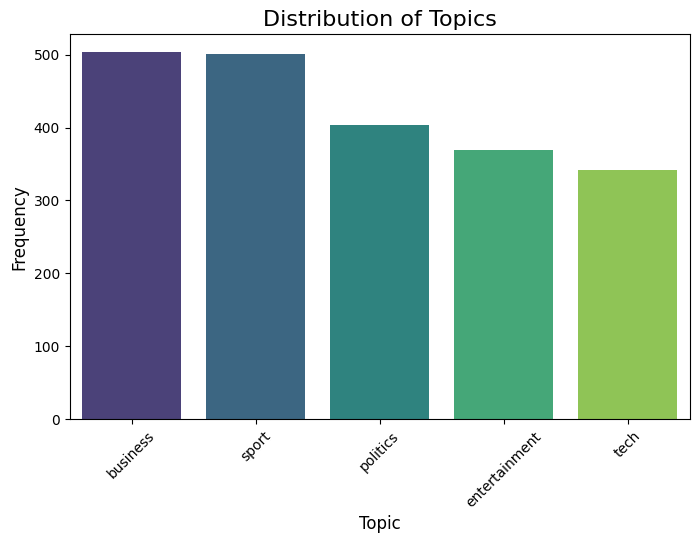

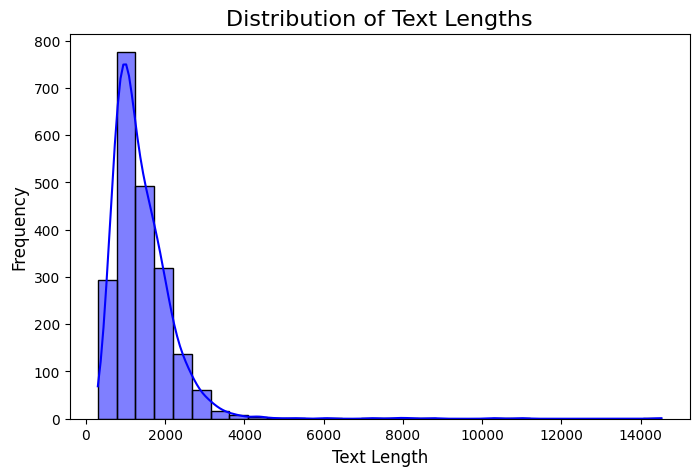

np.int64(0)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Distribution of Topics
topic_counts = data['topic'].value_counts()

# Bar chart for topic distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Distribution of Topics', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Step 2: Analyze Text Lengths
data['text_length'] = data['text'].apply(len)

# Plotting distribution of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Step 3: Check for Duplicates
duplicates = data.duplicated(subset=['text'], keep=False).sum()

# Output number of duplicates for reference
duplicates


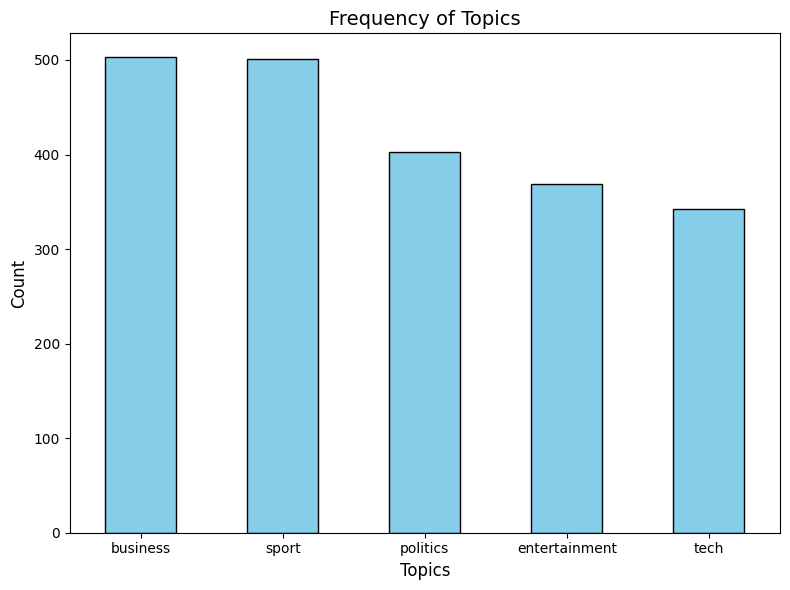

In [46]:
# Calculate the frequency of each topic
topic_counts = data['topic'].value_counts()

# Plot the frequency of topics
plt.figure(figsize=(8, 6))
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Topics', fontsize=14)
plt.xlabel('Topics', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\nthuy\AppData\Local\Temp\ipykernel_7404\1924459584.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_freq_df, x='Frequency', y='Word', palette='viridis', hue=None, legend=False)


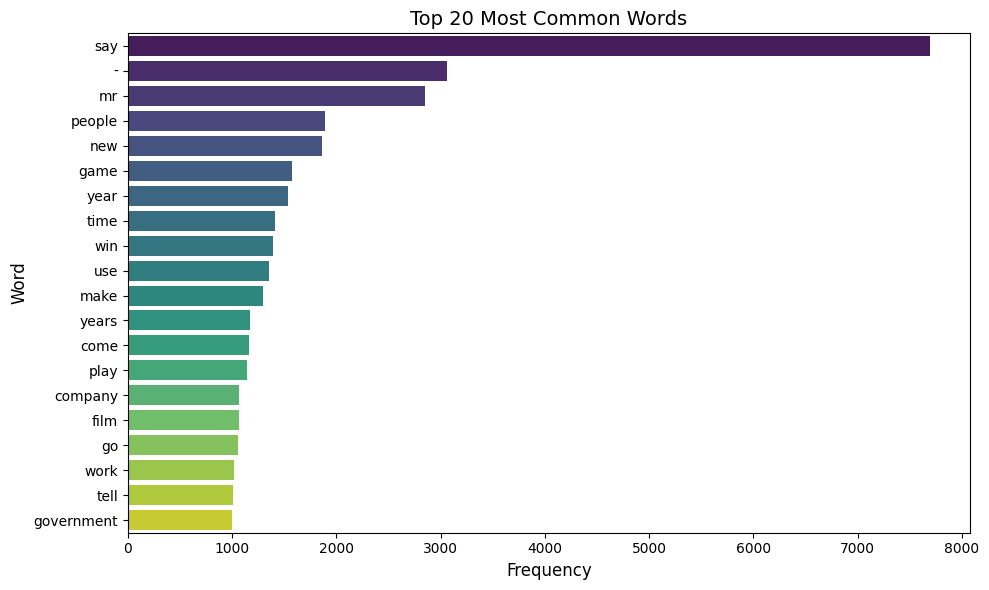

(          Word  Frequency
 0          say       7696
 1            -       3058
 2           mr       2851
 3       people       1890
 4          new       1865
 5         game       1574
 6         year       1534
 7         time       1409
 8          win       1388
 9          use       1358
 10        make       1296
 11       years       1171
 12        come       1164
 13        play       1144
 14     company       1063
 15        film       1062
 16          go       1061
 17        work       1021
 18        tell       1013
 19  government       1001,
 {'sport': [('say', 908),
   ('win', 781),
   ('game', 633),
   ('play', 604),
   ('-', 472)],
  'politics': [('say', 2451),
   ('mr', 1613),
   ('-', 734),
   ('labour', 727),
   ('party', 671)],
  'tech': [('say', 1599),
   ('use', 853),
   ('people', 826),
   ('game', 826),
   ('phone', 484)],
  'business': [('say', 1912),
   ('-', 766),
   ('company', 622),
   ('year', 599),
   ('mr', 596)],
  'entertainment': [('film', 910)

In [47]:
from collections import Counter
import seaborn as sns

# Tokenize the text data into words
words = all_text.split()

# Calculate the frequency of the top 20 most common words
word_freq = Counter(words).most_common(20)

# Convert to DataFrame for visualization
word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

# Adjust the bar plot to address the FutureWarning
plt.figure(figsize=(10, 6))
sns.barplot(data=word_freq_df, x='Frequency', y='Word', palette='viridis', hue=None, legend=False)
plt.title('Top 20 Most Common Words', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze most common words by topic
topic_word_freq = {}
for topic in data['topic'].unique():
    topic_text = ' '.join(data[data['topic'] == topic]['text'].astype(str))
    topic_word_freq[topic] = Counter(topic_text.split()).most_common(5)

word_freq_df, topic_word_freq